<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ydata_profiling import ProfileReport
import re
import itertools
import phik
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tqdm import tqdm
import pickle

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 500)

random.seed(42)
np.random.seed(42)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Ответ: фиксируем сид, чтобы "зафиксировать" случайность (если она есть) и результат стал воспроизводимым

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [3]:
# убрали единицы измерения bhp из max_power, перевели в float, некорректные значения заменили на 0, пропуски оставили как есть

for i in range(0, len(df_train)):
  try:
    ffil_value = float(df_train.loc[i, 'max_power'][:-4])
    df_train.loc[i, 'max_power'] = ffil_value

  except:
    if df_train.loc[i, 'max_power'] in [np.nan, 'nan']:
      continue
    elif df_train.loc[i, 'max_power'] == '0':
      ffil_value = float(df_train.loc[i, 'max_power'])
      df_train.loc[i, 'max_power'] = ffil_value
    else:
      df_train.loc[i, 'max_power'] = 0

##### Колонки с пропусками

Колонки с пропусками:
- mileage
- engine
- max_power
- torque
- seats

In [4]:
df_train.isna().sum()[df_train.isna().sum() > 0]

mileage      202
engine       202
max_power    196
torque       203
seats        202
dtype: int64

##### Дубликаты

Дубликаты есть: 
- Строчек с дубликатами: 985 из 6999, первую строку не помечаем как дубликат
- Доля дубликатов: 14.07% -> многовато и желательно удалить, так как могут исказать результаты моделей

In [5]:
df_train.duplicated(keep='first').sum()

np.int64(985)

In [6]:
df_train.duplicated().sum() / len(df_train)

np.float64(0.14073439062723248)

Выводы:
- Первое, что смутило: 493 строчки с дублями, что расходится с 985 выше, потому что в ydata-profilling считаем группы дубликатов (у скольких  строк есть дубли и неважно 1 у них дубль или 10). В пандасе считаем все дубли, кроме первой строки
- Есть пропуски -> нужно будет либо удалить строки с пропусками, либо заполнить их
- Больше половины колонок - не числовые -> нужно будет кодировать
- По переменным:
    - year: в датасете в основном более новые автомобили (после 2010 года). Есть корреляция с km_driven (пробегом) и ценой, что логично: но не логично, что чем старее авто, тем меньше пробег и выше цена (??)
    - selling_price: целевая переменная, распределение скошено вправо - много дешевых авто и мало дорогих
    - km_driven: снова распределение скошено вправо, в основном автомобили с небольшим пробегом
    - fuel: большинство авто на бензине или дизельные
    - seller_type: преобладают частные продавцы
    - transmission: преобладает механика -> можно закодировать как 0 или 1
    - owner: большинство авто - с первым владельцем 
    - mileage: есть пропуски, но всего 2.9% -> можно заполнить медианой, так как это больше числовая переменная (расход бензина на км), а не категориальная
    - engine: есть пропуски, но всего 2.9% -> можно заполнить медианой, похоже на объем двигателя и можно считать числовой переменной
    - max_power: есть пропуски, но всего 2.8% -> можно заполнить медианой, распределение скошено вправо
    - torque: есть пропуски, но всего 2.9% -> можно заполнить неизвестной категорией, похоже, что вращение колеса??
    - seats: есть пропуски, но всего 2.9% -> можно заполнить медианой, преобладают 5-местные авто (обычные легковые машины)
- Числовые переменные нужно будет, например, стандартизовать, так как разные масштабы, а также попробовать логарифмировать скошенные переменные, возможно выиграем в качестве модели
- Категориальные переменные нужно будет закодировать, например, one-hot кодированием (до 10 категорий), и стоит mileage и engine привести к типу числовой переменной, а torque закодировать Mean Target кодированием, так как там много уникальных значений
- Потенциально есть мультиколлинеарность: year и km_driven сильно скоррелированы, возможно стоит оставить только один из них, так как для линейных моделей мультиколинеарность вредна (особенно без регуляризации и если хотим интерпретировать коэффициенты): неправильные стандратные ошибки, широкие доверительные интервалы, возможны  странные знаки и значения коэффициентов


In [7]:
all_dup  = df_train.duplicated(keep=False).sum()
not_first_dup = df_train.duplicated(keep="first").sum()
all_dup - not_first_dup

np.int64(493)

In [118]:
ProfileReport(df_train, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 509.64it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

Выводы:
- По числовым переменным:
    - среднее и медиана сильно отличаются для selling_price внутри train и test -> распределение скошено вправо, потенциальный признак выбросов 
    - кроме того, максимальное значение selling_price в test 6 млн против 10 млн в train -> можем переобучится на высокие цены в трейне
    - аналогичная ситуация с km_driven: среднее и медиана сильно отличаются внутри train и test примерно на 10к -> распределение скошено вправо, потенциальный признак выбросов. И также в train попало более аномальное значение в максимум
    - с year и seats ситуация лучше: среднее и медиана близки внутри train и test, а также между ними -> сопоставимые наборы данных
- По категориальным переменным:
    - name: название авто, не иформативная переменная для модели
    - fuel, seller_type, transmission, owner по моде внутри train и test одинаковые -> сопоставимые наборы данных
    - в идеале mileage, engine, max_power преобразовать в числовые, избавившись от единиц измерения
    - мода по torque внутри train и test отличается, но в этой колонке много уникальных значений, поэтому сложно судить о сопоставимости наборов данных
- В целом train и test сопоставимы, но в train есть более аномальные значения по целевой переменной и пробегу, что может негативно повлиять на качество модели

Поскольку делаю задание последовательно, а предобработка будет с следующей части, то в этой части оставила все без изменений

##### Сравнение числовых

In [9]:
# your code here
df_train.describe(include='number').round(1)

year  selling_price  km_driven   seats
count  6999.0         6999.0     6999.0  6797.0
mean   2013.8       639515.2    69584.6     5.4
std       4.1       808941.9    57724.0     1.0
min    1983.0        29999.0        1.0     2.0
25%    2011.0       254999.0    35000.0     5.0
50%    2015.0       450000.0    60000.0     5.0
75%    2017.0       675000.0    97000.0     5.0
max    2020.0     10000000.0  2360457.0    14.0

In [10]:
df_test.describe(include='number').round(1)

year  selling_price  km_driven  seats
count  1000.0         1000.0     1000.0  981.0
mean   2013.7       617901.0    71393.3    5.4
std       4.0       758553.9    48486.2    0.9
min    1995.0        31000.0     1303.0    4.0
25%    2011.0       250000.0    37000.0    5.0
50%    2014.0       434999.0    61500.0    5.0
75%    2017.0       670000.0   100000.0    5.0
max    2020.0      6000000.0   375000.0    9.0

##### Сравнение категориальных

In [11]:
df_train.describe(include='object')

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine  max_power          torque  
count        6797     6797     6803.0            6796  
unique        386      120      313.0             419  
top     18.9 kmpl  1248 CC       74.0  190Nm@ 2000rpm  
freq          197      885      330.0             468

In [12]:
df_test.describe(include='object')

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

- Теперь когда мы исключили таргет дубликатов стало больше: 1159 строчка (не считаем первую сроку за дубль)
- После удаление дубликатов осталось 5840 строк
- Потенциально могут быть другие скрытые дубли, например, если прошло время и выложили новое объявление опродаже, но уже с бОльшим пробегом или перевыложили, если поменялс тип селлера, кроме того, не исключены ошибки ввода информации об авто, например, для одного и того же авто есть 2 строки с отличием в одной колонке, и в одной из строк аномальное значение, например, год = 0000 или 9999
- Как можно отлавливать:
    - просто: считать в каком количестве признаков объекты совпадают, если 1-2 (только для нашего датасета), то можно проверять на дубликат несколько выборочных и если подверждаем (аномальное значение или ошибка ввода), то оставляем только одну строку
    - сложнее: считать похожесть объектов по признакам (например, по косинусной близости или евклидовой) и если близость выше какого-то порога, то проверять на дубликат. Порог можно подобрать графически, посмотрев на распределение похожестей

In [13]:
duplicated_flg = df_train.drop('selling_price', axis=1).duplicated(keep='first')
len(df_train[duplicated_flg])

1159

In [14]:
# выводим все дублbткаты (и даже первую срочку)
df_train[df_train.drop('selling_price', axis=1).duplicated(keep=False)].sort_values('name').head(10)

name  year  selling_price  km_driven  \
1703  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
6307  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
6704               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
1836               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
117             Audi Q5 35TDI Premium Plus  2018        3975000      31800   
2787            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
6640            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
4485            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
1595            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
1337            Audi Q5 35TDI Premium Plus  2018        3975000      31800   

        fuel seller_type transmission        owner     mileage   engine  \
1703  Diesel      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC   
6307  Diesel      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC   
6704  Diesel  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   
1836  Diesel  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   
117   Diesel      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC   
2787  Diesel      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC   
6640  Diesel      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC   
4485  Diesel      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC   
1595  Diesel      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC   
1337  Diesel      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC   

     max_power               torque  seats  
1703    174.33  380Nm@ 1750-2500rpm    5.0  
6307    174.33  380Nm@ 1750-2500rpm    5.0  
6704     241.4  580Nm@ 1400-3250rpm    5.0  
1836     241.4  580Nm@ 1400-3250rpm    5.0  
117      188.0  400nm@ 1750-3000rpm    5.0  
2787     188.0  400nm@ 1750-3000rpm    5.0  
6640     188.0  400nm@ 1750-3000rpm    5.0  
4485     188.0  400nm@ 1750-3000rpm    5.0  
1595     188.0  400nm@ 1750-3000rpm    5.0  
1337     188.0  400nm@ 1750-3000rpm    5.0

In [15]:
cols_to_check = df_train.columns.difference(['selling_price'])
cols_to_check

Index(['engine', 'fuel', 'km_driven', 'max_power', 'mileage', 'name', 'owner',
       'seats', 'seller_type', 'torque', 'transmission', 'year'],
      dtype='object')

In [16]:
df_train.drop_duplicates(subset=cols_to_check, keep='first', inplace=True)

In [17]:
df_train.reset_index(drop=True, inplace=True)

In [18]:
len(df_train)

5840

In [19]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [ ]:
def extract_torque_rpm_max(text):
    """
    Извлекаем первое число для torque и второе для max_torque_rpm (второе число из диапазона, если есть диапазон)
    """
    # паттерн для извлечения чисел, тут обратилась к deepseek, потому что подзабыла синтаксис регекса и работу с группами
    # ищем паттерн вида число + единица измерения (опционально) + @/at + число или диапазон чисел
    pattern = r'(\d+\.?\d*)\s*(Nm|kgm|nm)?\s*(?:@|at)\s*(\d+(?:-\d+)?)'
    match = re.search(pattern, str(text), re.IGNORECASE)
    
    if match:
        torque_value = float(match.group(1))
        unit = match.group(2) if match.group(2) else 'Nm'  # если единиц нет, считаем Nm
        
        if unit.lower() == 'kgm':
            torque_value = torque_value * 9.81  # конвертация kgm → Nm
        
        # проверка: число или диапазон
        rpm_range = match.group(3)
        if '-' in rpm_range:
            rpm_min, rpm_max = rpm_range.split('-')
            rpm = rpm_max  # берем максимальное число
        else:
            rpm = rpm_range
            
        return torque_value, rpm
    else:
        return None, None

In [21]:
def process_category_to_float(df_, cat_columns):
    """
    Приводим категориальные колонки к числовому типу 
    """

    df = df_.copy() # чтобы не делать inplace в самом df

    for col in cat_columns:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace(',', '') # где-то были запятые - заменяем на точку

        if col == 'torque':
            df[[col, 'max_torque_rpm']] = df[col].apply(lambda x: pd.Series(extract_torque_rpm_max(x)))
            df[col] = df[col].astype(float)
            df['max_torque_rpm'] = df['max_torque_rpm'].astype(float)

        else:
            df[col] = df[col].str.extract(r'([0-9.,]+)').astype(float)
            
    return df

In [22]:
df_train = process_category_to_float(df_train, ['mileage', 'engine', 'max_power', 'torque'])
df_test = process_category_to_float(df_test, ['mileage', 'engine', 'max_power', 'torque'])

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






1. Лучше брать медиану, так как она менее чувствительна к выбросам, а у нас как раз скошенные распределения 
2. Считаем медиану только по тренировочным данным для `train` и `test`, так как для реальных новых данных с пропуском у нас нет значения

In [23]:
# проверяем, совпадает ли по колонкам с пропусками train и test

set(df_test.isna().sum()[df_test.isna().sum() > 0].index) - set(df_train.isna().sum()[df_train.isna().sum() > 0].index)

set()

In [24]:
df_train.describe().round(1)

year  selling_price  km_driven  mileage  engine  max_power  torque  \
count  5840.0         5840.0     5840.0   5654.0  5654.0     5657.0  5641.0   
mean   2013.4       522960.1    73952.2     19.4  1435.4       88.1   163.7   
std       4.1       535432.0    60071.1      4.1   492.5       32.2    90.9   
min    1983.0        29999.0        1.0      0.0   624.0        0.0     5.7   
25%    2011.0       250000.0    39000.0     16.8  1197.0       68.0    99.0   
50%    2014.0       405000.0    70000.0     19.4  1248.0       81.9   151.0   
75%    2017.0       640000.0   100000.0     22.3  1498.0      100.0   200.0   
max    2020.0     10000000.0  2360457.0     42.0  3604.0      400.0   789.0   

        seats  max_torque_rpm  
count  5654.0          5641.0  
mean      5.4          3048.0  
std       1.0           926.0  
min       2.0          1400.0  
25%       5.0          2250.0  
50%       5.0          3000.0  
75%       5.0          4000.0  
max      14.0         21800.0

In [25]:
def fill_na_median_train(df_):
    """
    Заполняем пропуски медианой в чиcловых колонках по трейну
    """

    map_na = {}

    df = df_.copy()
    cols = df.select_dtypes(include='number').columns

    for col in cols:
        fill_value = df[col].median()
        df[col] = df[col].fillna(fill_value)

        # для теста
        map_na[col] = fill_value

    return df, map_na

def fill_na_median_test(df_, map_na):
    """
    Заполняем пропуски медианой по словарю с колонкой и значением из трейна
    """
    df = df_.copy()

    for col, fill_value in map_na.items():
        df[col] = df[col].fillna(fill_value)

    return df

In [26]:
df_train, map_na = fill_na_median_train(df_train)
df_test = fill_na_median_test(df_test, map_na)

In [27]:
map_na

{'year': np.float64(2014.0),
 'selling_price': np.float64(405000.0),
 'km_driven': np.float64(70000.0),
 'mileage': np.float64(19.369999999999997),
 'engine': np.float64(1248.0),
 'max_power': np.float64(81.86),
 'torque': np.float64(151.0),
 'seats': np.float64(5.0),
 'max_torque_rpm': np.float64(3000.0)}

In [28]:
df_train.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64

In [29]:
df_test.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

1. У seats всего 9 уникальных значений и они счетные 
2. Однако я бы рассматривала такую переменную, хотя бы как порядковую, так как потенциально 1) говорит о размере авто 2) ранжирует

In [30]:
def cols_to_int(df_, columns=['engine', 'seats']):

    df = df_.copy()

    for col in columns:
        df[col] = df[col].astype(int)

    return df

In [31]:
df_train = cols_to_int(df_train)
df_test = cols_to_int(df_test)

In [32]:
df_train.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine              int64
max_power         float64
torque            float64
seats               int64
max_torque_rpm    float64
dtype: object

In [33]:
df_test.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine              int64
max_power         float64
torque            float64
seats               int64
max_torque_rpm    float64
dtype: object

In [34]:
df_train['seats'].value_counts(normalize=True)

seats
5     0.790753
7     0.136986
8     0.032705
4     0.016096
9     0.011644
6     0.008219
10    0.003082
2     0.000342
14    0.000171
Name: proportion, dtype: float64

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

Новые колонки: 
- mileage и engine: медиана и среднее почти совпадают как внутри датасетов, так и между train и test
- max_power и torque и max_torque_rpm: более аномальное макс значение в train, со средними и медианами - почти сбалансировано

Заполнение пропусков:
- не сдвинуло бы распределения, так как мы заполнили медианой - центральным значением -> не меняем форму распределения

##### Сравнение числовых

In [35]:
df_train.describe(include='number').round(1)

year  selling_price  km_driven  mileage  engine  max_power  torque  \
count  5840.0         5840.0     5840.0   5840.0  5840.0     5840.0  5840.0   
mean   2013.4       522960.1    73952.2     19.4  1429.4       87.9   163.2   
std       4.1       535432.0    60071.1      4.0   485.7       31.7    89.4   
min    1983.0        29999.0        1.0      0.0   624.0        0.0     5.7   
25%    2011.0       250000.0    39000.0     17.0  1197.0       68.0   102.0   
50%    2014.0       405000.0    70000.0     19.4  1248.0       81.9   151.0   
75%    2017.0       640000.0   100000.0     22.3  1498.0       99.0   200.0   
max    2020.0     10000000.0  2360457.0     42.0  3604.0      400.0   789.0   

        seats  max_torque_rpm  
count  5840.0          5840.0  
mean      5.4          3046.3  
std       1.0           910.1  
min       2.0          1400.0  
25%       5.0          2400.0  
50%       5.0          3000.0  
75%       5.0          4000.0  
max      14.0         21800.0

In [36]:
df_test.describe(include='number').round(1)

year  selling_price  km_driven  mileage  engine  max_power  torque  \
count  1000.0         1000.0     1000.0   1000.0  1000.0     1000.0  1000.0   
mean   2013.7       617901.0    71393.3     19.3  1454.9       90.8   167.3   
std       4.0       758553.9    48486.2      4.0   522.0       34.9    92.3   
min    1995.0        31000.0     1303.0      0.0   624.0       34.2     7.8   
25%    2011.0       250000.0    37000.0     16.6  1197.0       69.0   104.0   
50%    2014.0       434999.0    61500.0     19.4  1248.0       82.4   151.0   
75%    2017.0       670000.0   100000.0     22.3  1582.0      102.0   204.2   
max    2020.0      6000000.0   375000.0     32.3  3604.0      280.0   620.0   

        seats  max_torque_rpm  
count  1000.0          1000.0  
mean      5.4          3096.5  
std       0.9           875.5  
min       4.0          1500.0  
25%       5.0          2500.0  
50%       5.0          3000.0  
75%       5.0          4000.0  
max       9.0          5200.0

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

##### Шаг 1

1. Можно, но именно предположить:
    - полезно использовать аргумент kind со значением 'reg' - строим регрессионную прямую
    - price положительно связана с year, max_power, torque и тд: scatter и прямая с положительным наклоном на это указывают
    - price отрицательно связана пробегом (km_driven) и miliage: scatter и прямая с отрицательным наклоном на это указывают
    - price не связана с max_torque_rpm, так как прямая почти без наклона
2. И выдвинуть гипотезы о наличии корреляции и ее направленности (но надо проверят стат значимость):
    - если прямая имеет положительный наклон (= точки на scatter в первом и третьем квадранте графика), то скорее всго есть положительная корреляция
    - если прямая имеет отрицательный наклон (= точки на scatter во втвором и четвертом квадранте графика), то скорее всго есть отрицательная корреляция
    - чем круче наклон, тем больше может быть значение коэффициента корреляции, для пологих прямых (точки как облако) корреляция скорее всего равна 0

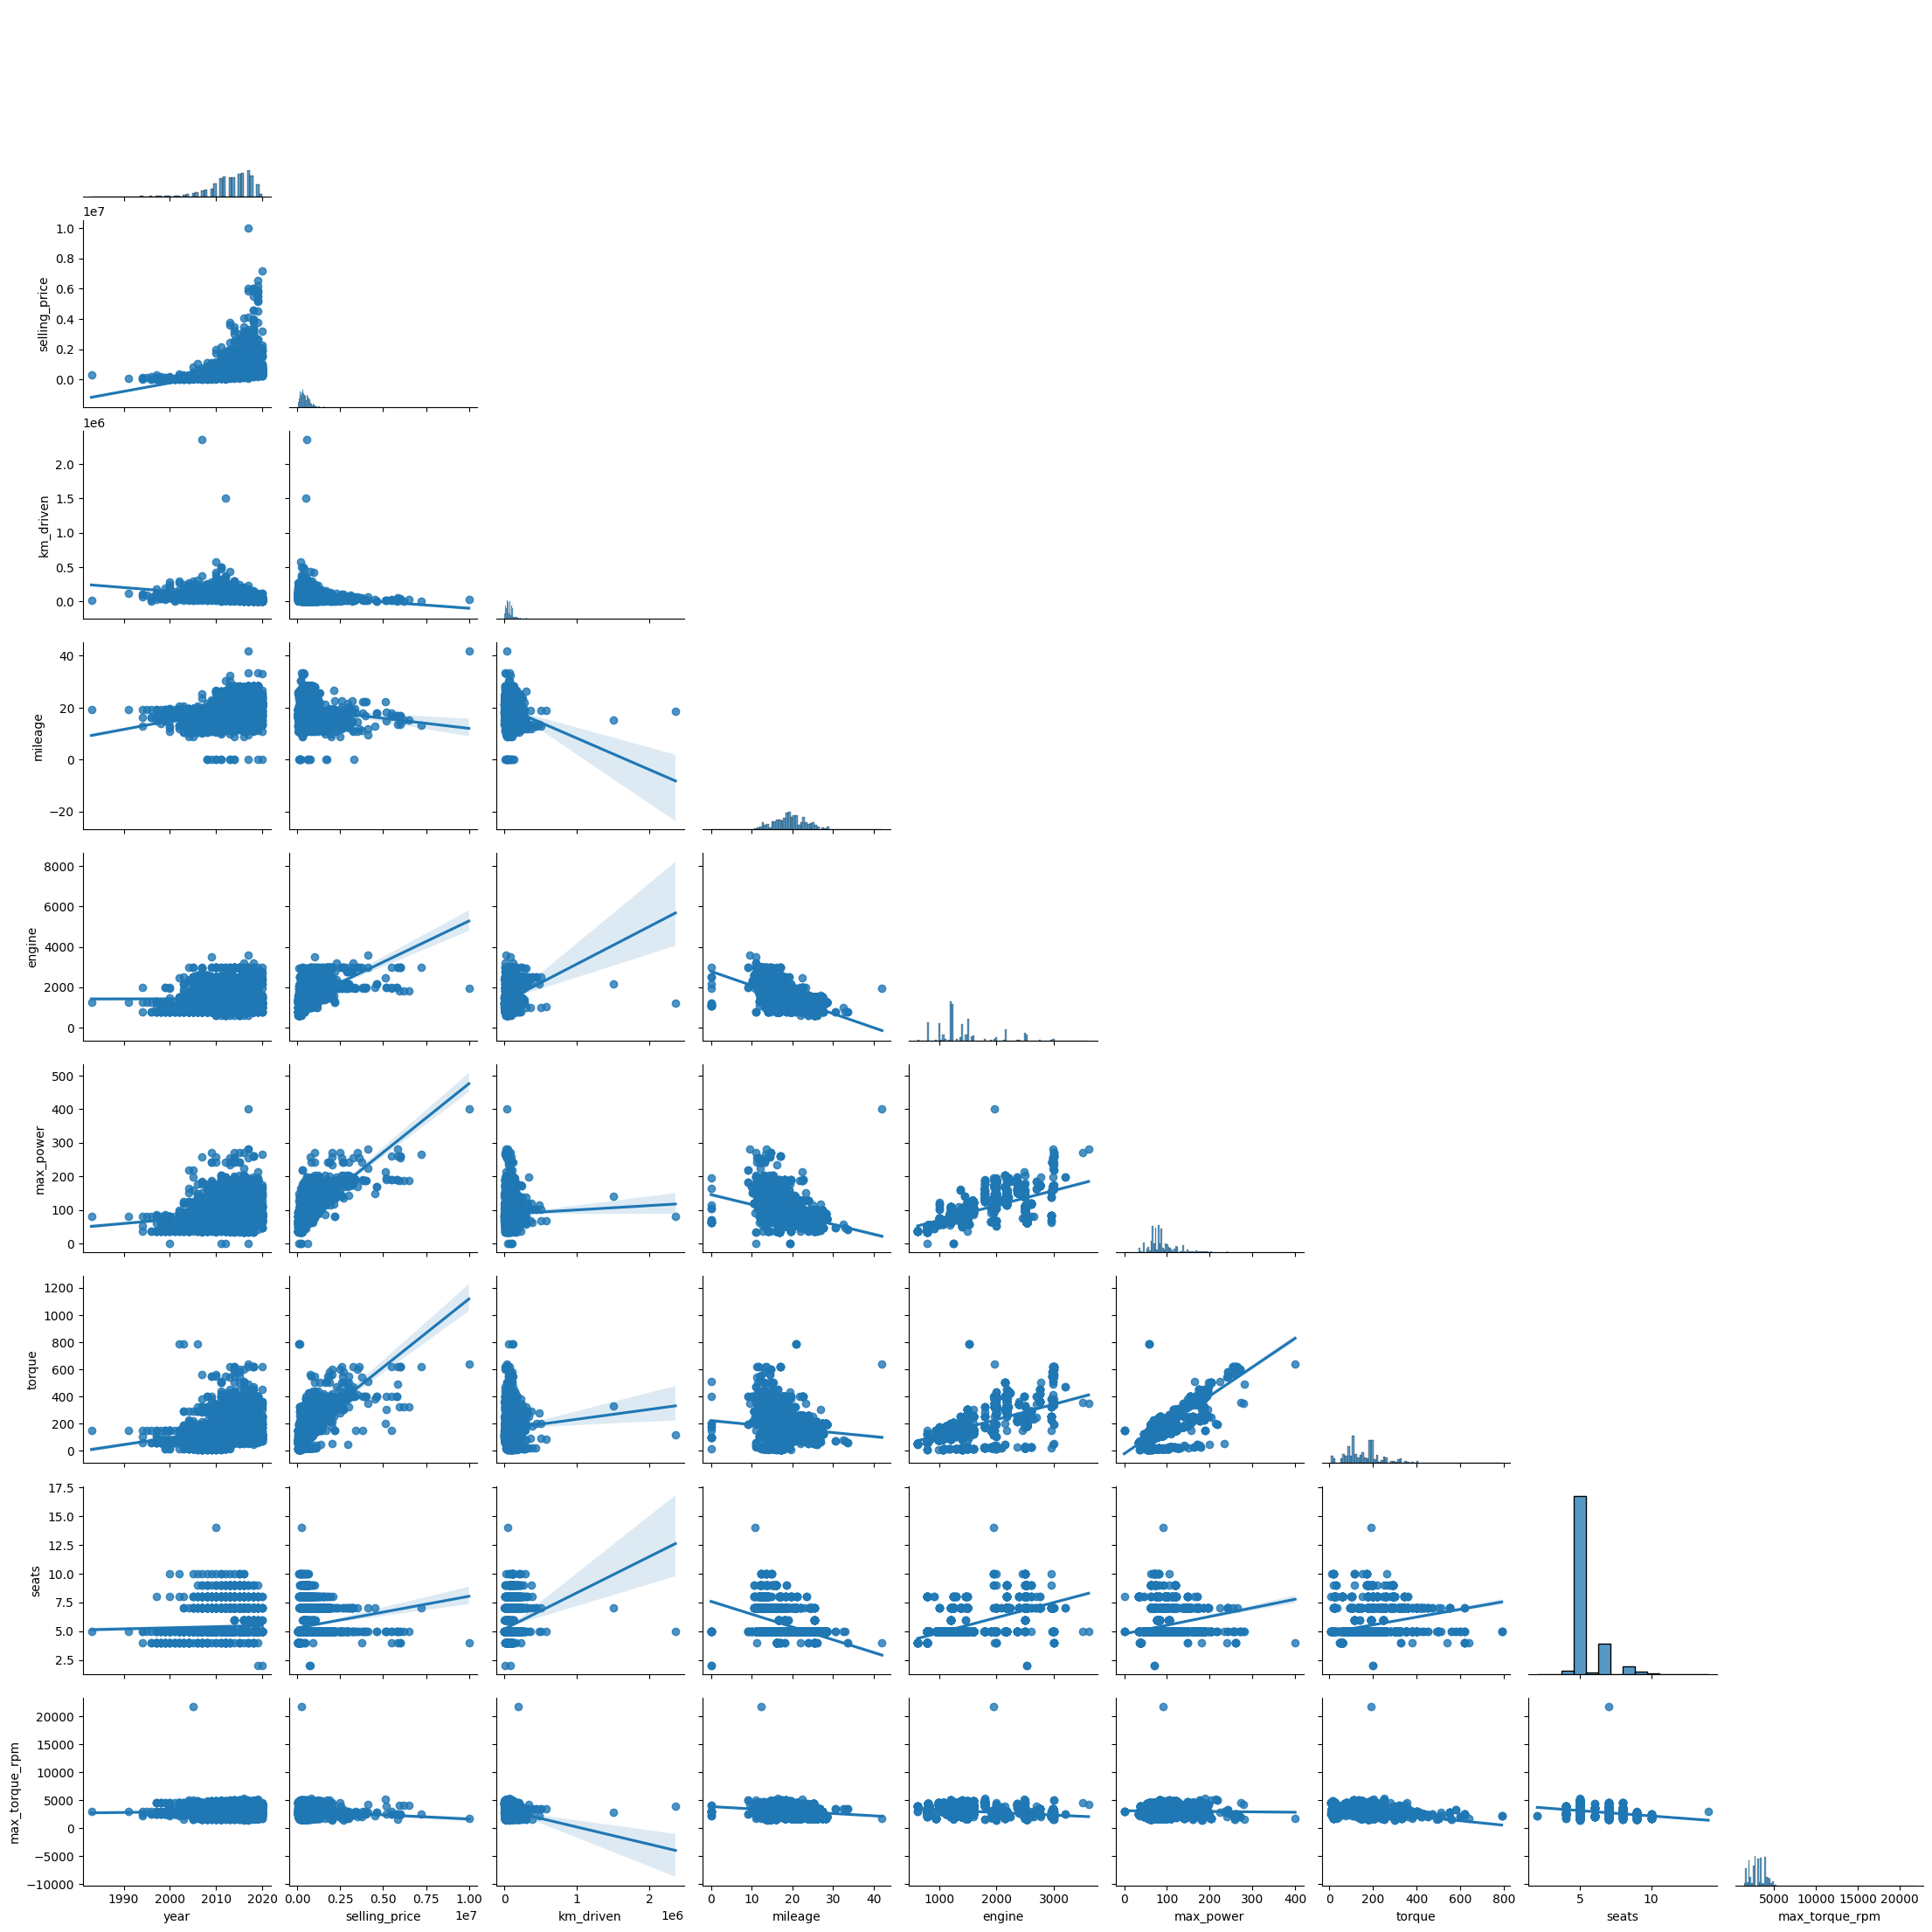

In [37]:
sns.pairplot(
    data=df_train,
    corner=True,
    kind='reg')

##### Шаг 2

- В целом с зависимой переменной видим такие же паттерны связи по переменым
- Гистограммы по переменным тоже повторяют форму (скошенность), однако есть проблема с диапазонами: в описательных статистиках видели, что в трейне могут быть более аномальные значения -> распределения для трейна сильнее смещены и можем переобучиться на такие высокие значения
- Стоит понять, нужно ли убирать такие высокие значения из train или нам просто "не повезло", что в тесте таких значений нет

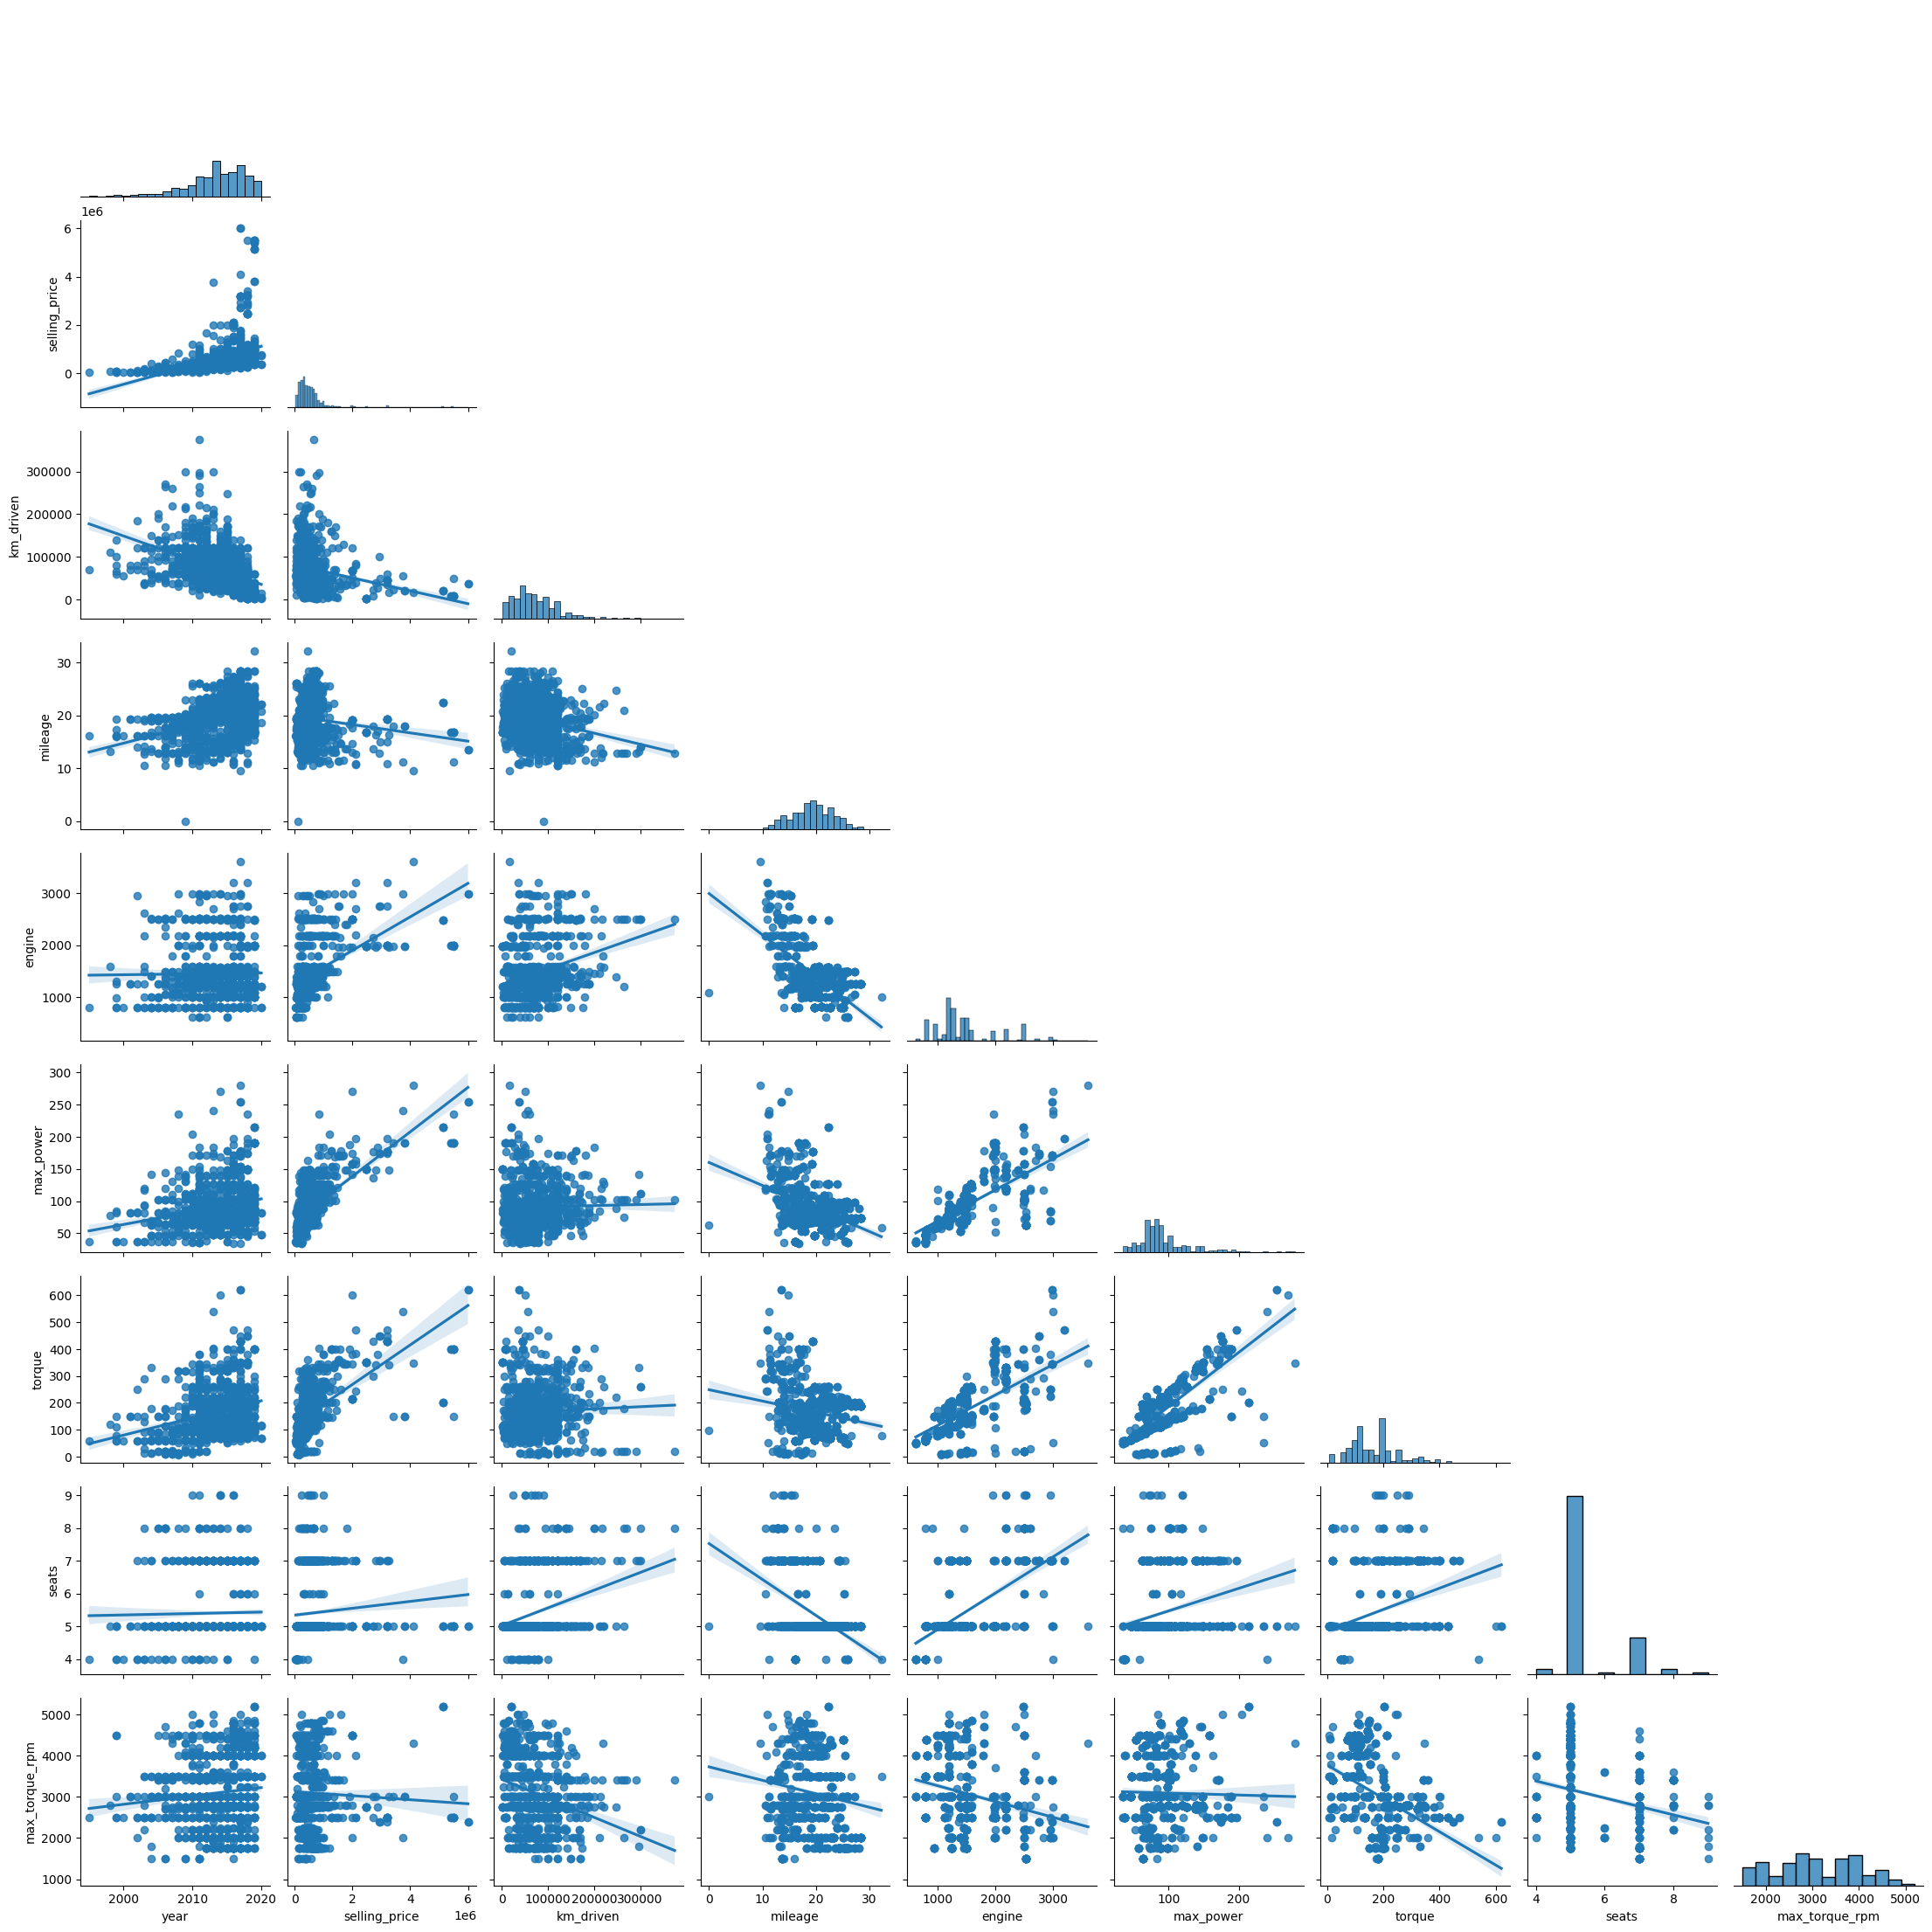

In [38]:
sns.pairplot(
    data=df_test,
    corner=True,
    kind='reg')

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

Ответы:
- year, engine: написала функцию для удобства, тжело немного искать по heatmap, так как цвета не совсем "говорящие" для около нулевых значений
- max_power, torque
- если брать km_driven (пробег?), то по знаку коэффициента корреляции - да, так и получается. Но по логике кажется, что подержанные авто должны иметь бОльший пробег, чем новые. Если вспомнить scatter, и увидеть скопление с 0 пробегом для старых авто, то можно предположить, что есть "кластер" старых-старых авто, возможно даже ретро (на это еще указывает скопление точек с высокой ценой и большим возрастом авто), которые просто стояли в качестве экспоната
- Пирсона (она стоит по дефолту)

In [39]:
def get_correlation_matrix(df, features_cols):

    """Смотрим на модуль коэффициента корреляции и сортируем по модулю коэффициента"""

    corr_ls = []

    for pair in itertools.combinations(features_cols, 2):

        corr_ls.append(
            {'pair': pair,
            'correlation': float(df[list(pair)].corr().iloc[1, 0]),
            'correlation_abs': abs(float(df[list(pair)].corr().iloc[1, 0]))
            }
        )
        
    df_corr = pd.DataFrame(corr_ls)

    return df_corr.sort_values(by='correlation_abs', ascending=False)

In [40]:
df_train_corr = df_train.select_dtypes(include='number').corr().round(5)

<Axes: >

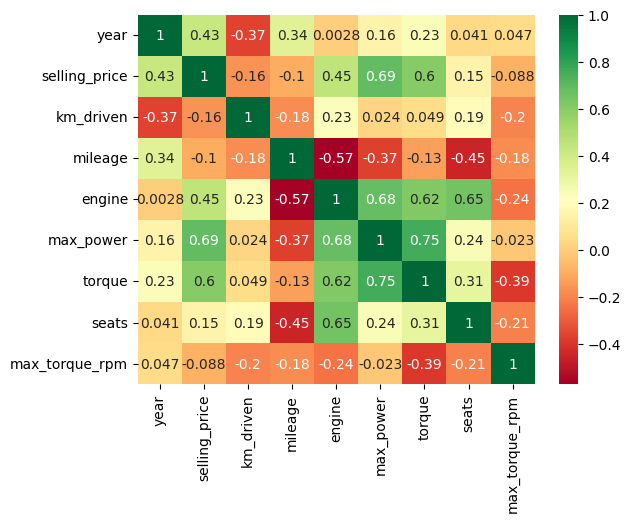

In [41]:
sns.heatmap(
    df_train_corr,
    cmap='RdYlGn',
    annot=True)

In [42]:
get_correlation_matrix(df_train, df_train.select_dtypes(include='number').columns).tail(5)

pair  correlation  correlation_abs
7        (year, max_torque_rpm)     0.047342         0.047342
6                 (year, seats)     0.041178         0.041178
17       (km_driven, max_power)     0.024379         0.024379
32  (max_power, max_torque_rpm)    -0.023190         0.023190
3                (year, engine)     0.002819         0.002819

In [43]:
get_correlation_matrix(df_train, df_train.select_dtypes(include='number').columns).head(5)

pair  correlation  correlation_abs
30         (max_power, torque)     0.754615         0.754615
11  (selling_price, max_power)     0.692725         0.692725
26         (engine, max_power)     0.681247         0.681247
28             (engine, seats)     0.652172         0.652172
27            (engine, torque)     0.616557         0.616557

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


1. Корреляция Спирмена, рассчитанная вручную, расходится сильно с библиотечной только по seats, это возникло из-за того, что в ручной реализации не учла поправку на повторы (в пандасе есть), а в колонке seats мало уникальных значений (все около 5). Это был полезный опыт, чтобы понять, как работает корреляция Спирмена под "капотом", поэтому оставлю так, но учту в будущем
2. С Пирсоном и Спирменом похожая ситуация: сильная корреляция selling_price с year и max_power и torque, например. Однако Спирмен показывает более сильную корреляцию, что сигналит о возможно нелинейной зависимости между этими переменными

##### Корреляция Спирмена

In [44]:
def calculate_rank(x):

    """
    Считаем ранг с учетом повторов
    """
    ranks_orig = np.argsort(np.argsort(x))
    v_c = np.unique(x, return_counts=True)[1]
    cum_sum_x = np.cumsum(v_c)

    all_ranks = []

    for enum_cum_sum, repeat in zip(enumerate(cum_sum_x), v_c):
        i, el = enum_cum_sum

        prev_value = cum_sum_x[i-1]+1 if i > 0 else 1
        right_ranks = [np.mean(np.arange(prev_value, cum_sum_x[i]+1))] * repeat
        all_ranks += right_ranks

    all_ranks = np.array(all_ranks)

    return all_ranks[ranks_orig]

In [45]:
def spearman_corr_manual(x, y):

    """
    Считаем ранговую корреляцию Спирмена
    """

    x = np.array(x)
    y = np.array(y)
    n = len(x)

    y_rank = calculate_rank(y)
    x_rank = calculate_rank(x) 

    return 1 - 6*(np.sum((np.power(x_rank - y_rank, 2))) / (n*(np.power(n, 2)-1)))

In [46]:
cols_for_corr = df_train.select_dtypes(include='number').columns
cols_combinations = itertools.combinations(cols_for_corr, 2)

In [47]:
df_corr_manual = pd.DataFrame(index=cols_for_corr, columns=cols_for_corr, dtype='float')

for col in cols_for_corr:
    df_corr_manual.loc[col, col] = 1.000

for pair in cols_combinations:
    x, y = pair
    corr_coef = spearman_corr_manual(df_train[x], df_train[y])
    df_corr_manual.loc[x, y] = np.round(corr_coef, 3)
    df_corr_manual.loc[y, x] = np.round(corr_coef, 3)

Text(0.5, 1.0, 'Ручной расчет корреляции')

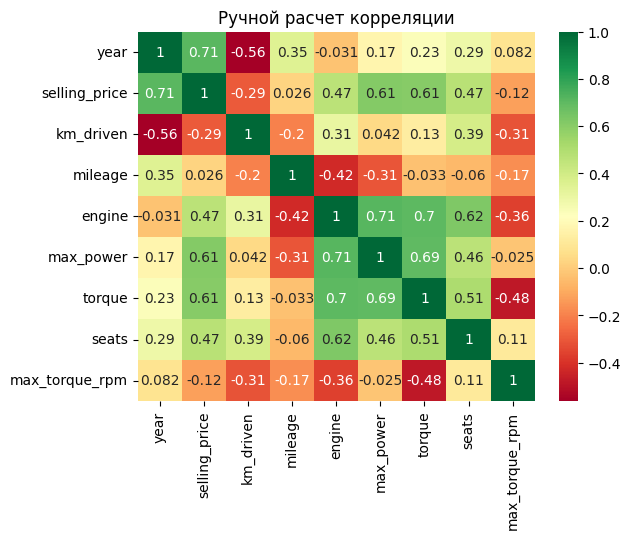

In [48]:
sns.heatmap(
    df_corr_manual,
    cmap='RdYlGn',
    annot=True)

plt.title('Ручной расчет корреляции')

Text(0.5, 1.0, 'Библиотечная реализация')

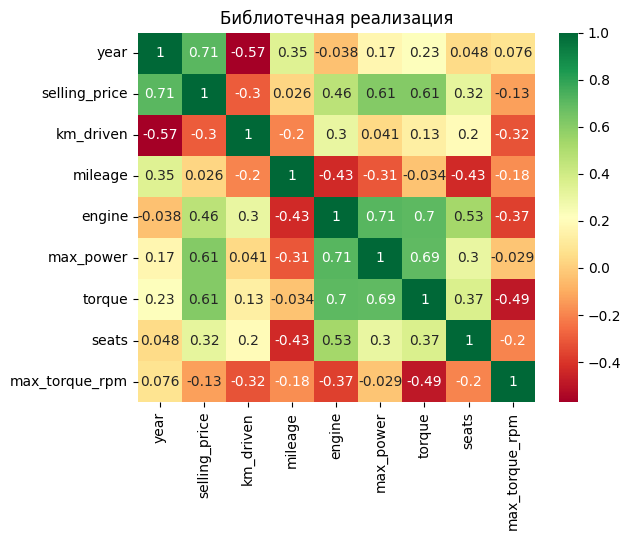

In [49]:
df_train_corr_spear = df_train.select_dtypes(include='number').corr(method='spearman').round(3)

sns.heatmap(
    df_train_corr_spear,
    cmap='RdYlGn',
    annot=True)

plt.title('Библиотечная реализация')

 ##### Коэффициент корреляции Фи

Выводы (дополнительные инсайты):

- по коэффициенту фи видно, что категориальная переменная fuel слабо (0.16) скоррелирована с целевой переменной selling_price -> возможно, не очень информативный признак для модели. При этом transmission и owner имеют более сильную корреляцию с selling_price -> могут быть более полезными признаками
- у millage коэффициент корреляции фи выше по значению, чем по Пирсону -> возможно, нелинейная зависимость с selling_price и стоит добавить, например, полиномиальные признаки. С torque и max_torque аналогичная ситуация

In [50]:
# 10 бинов по умолчанию
# name исключила, так как колонка содержит много уникальных значений и не особо информативна

ph = df_train.drop('name', axis=1).phik_matrix()

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


<Axes: >

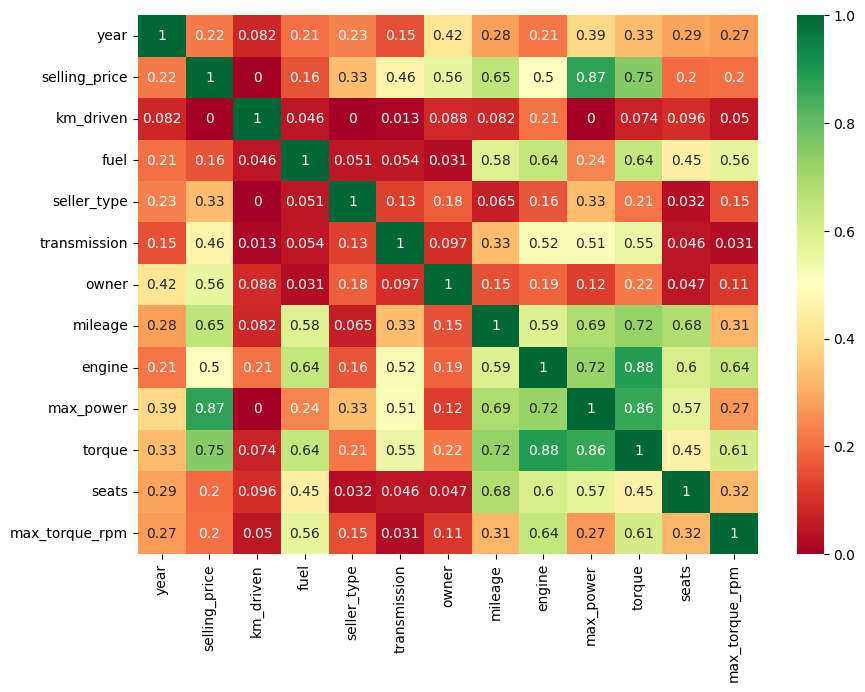

In [51]:
plt.figure(figsize=(10, 7))

sns.heatmap(
    ph, 
    cmap='RdYlGn',
    annot=True)

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

In [52]:
def get_boxplots(df, numeric_cols=True):
    
    if numeric_cols:
        cols = df.select_dtypes(include='number').columns
        n_cols = len(cols)
        n_per_row = 3
        n_rows = (n_cols + n_per_row - 1) // n_per_row
        fig, axes = plt.subplots(n_rows, n_per_row, figsize=(5*n_per_row, 4*n_rows))
        axes = axes.flatten()

        for i, col in enumerate(cols):
            sns.boxplot(data=df, x=col, ax=axes[i])
            axes[i].set_title(f'Boxplot для {col}')

        plt.tight_layout()
        plt.show()

    else:
        cols = df.drop('name', axis=1).select_dtypes(include='object').columns
        n_cols = len(cols)
        n_per_row = 4
        n_rows = (n_cols + n_per_row - 1) // n_per_row
        fig, axes = plt.subplots(n_rows, n_per_row, figsize=(5*n_per_row, 4*n_rows))
        axes = axes.flatten()

        for i, col in enumerate(cols):
            sns.boxplot(data=df, x=col, y='selling_price', ax=axes[i])
            axes[i].set_title(f'Boxplot для {col}')

        plt.tight_layout()
        plt.show()

##### Boxplots для числовых

1. Boxplot помогает получше взглянуть на распределения признаков и таргета, видно, что есть кандидаты на выбросы как по таргету, так и по независимыс переменным, например пробегу
2. И снова видим, что train и test сопоставимы по распределениям, но в train есть более аномальные значения
3. Категориальные boxplots показывают, что в целом распределения таргета по категориям похожи между train и test, но в малочастотных категориях есть перекосы

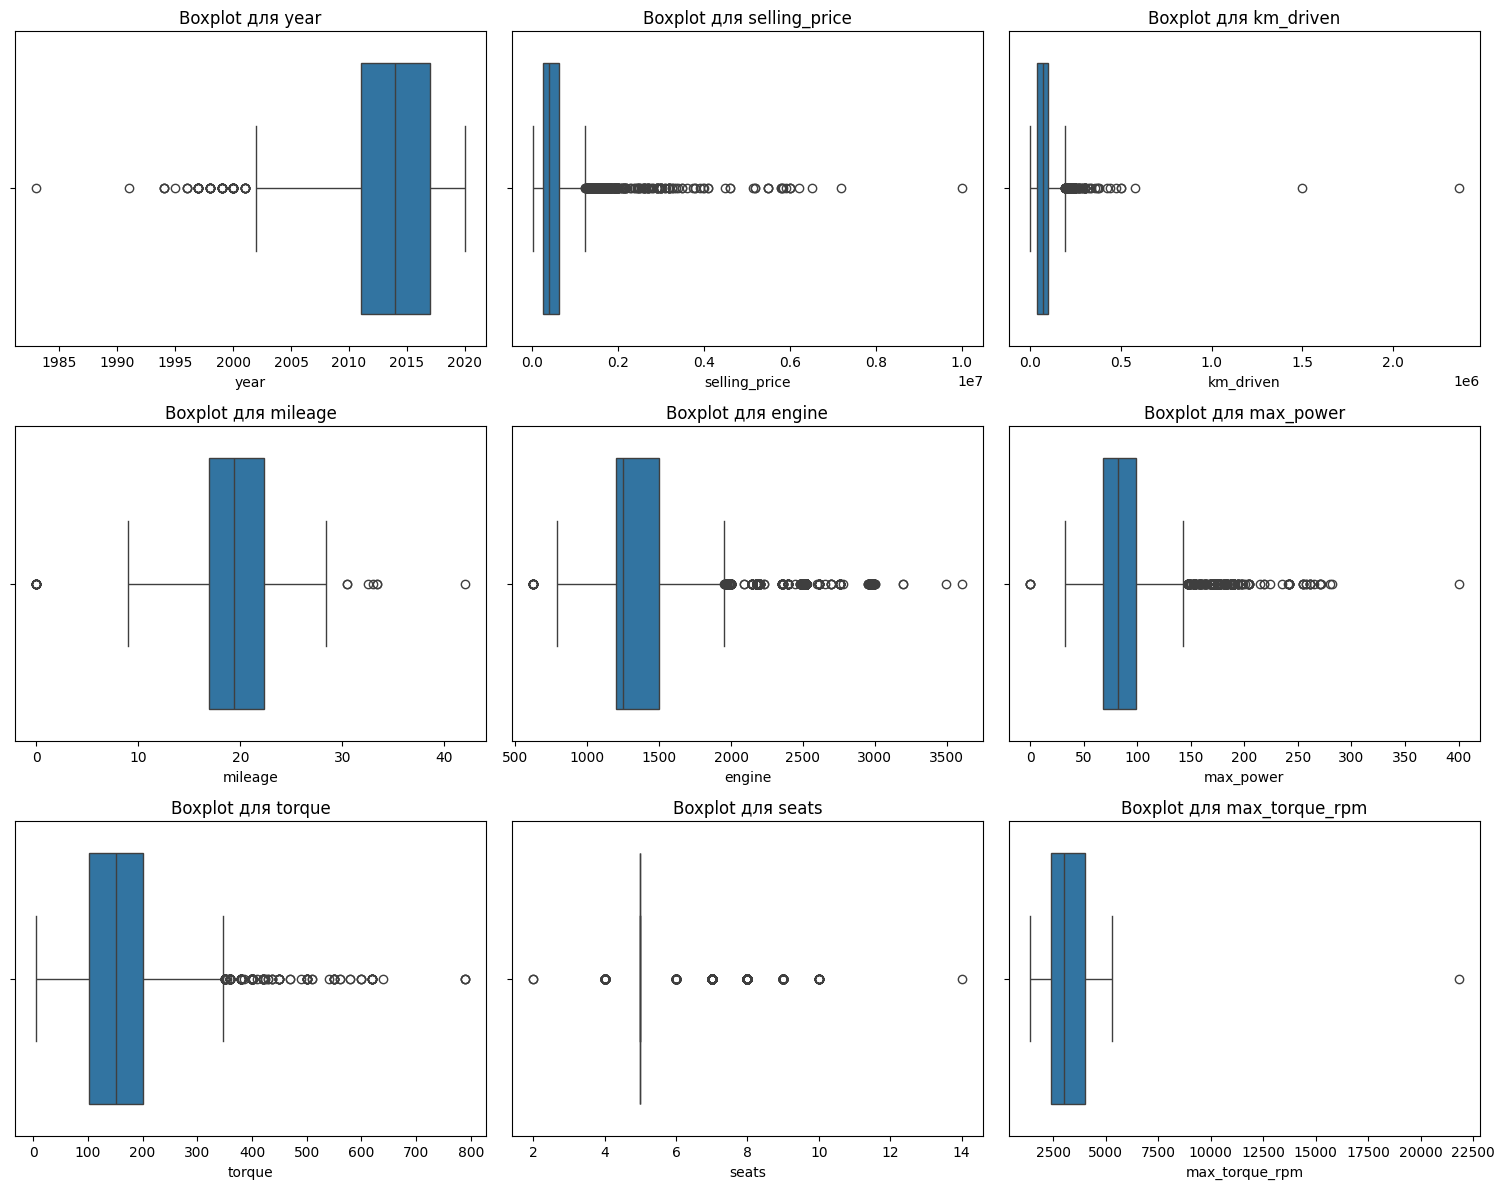

In [53]:
get_boxplots(df_train)

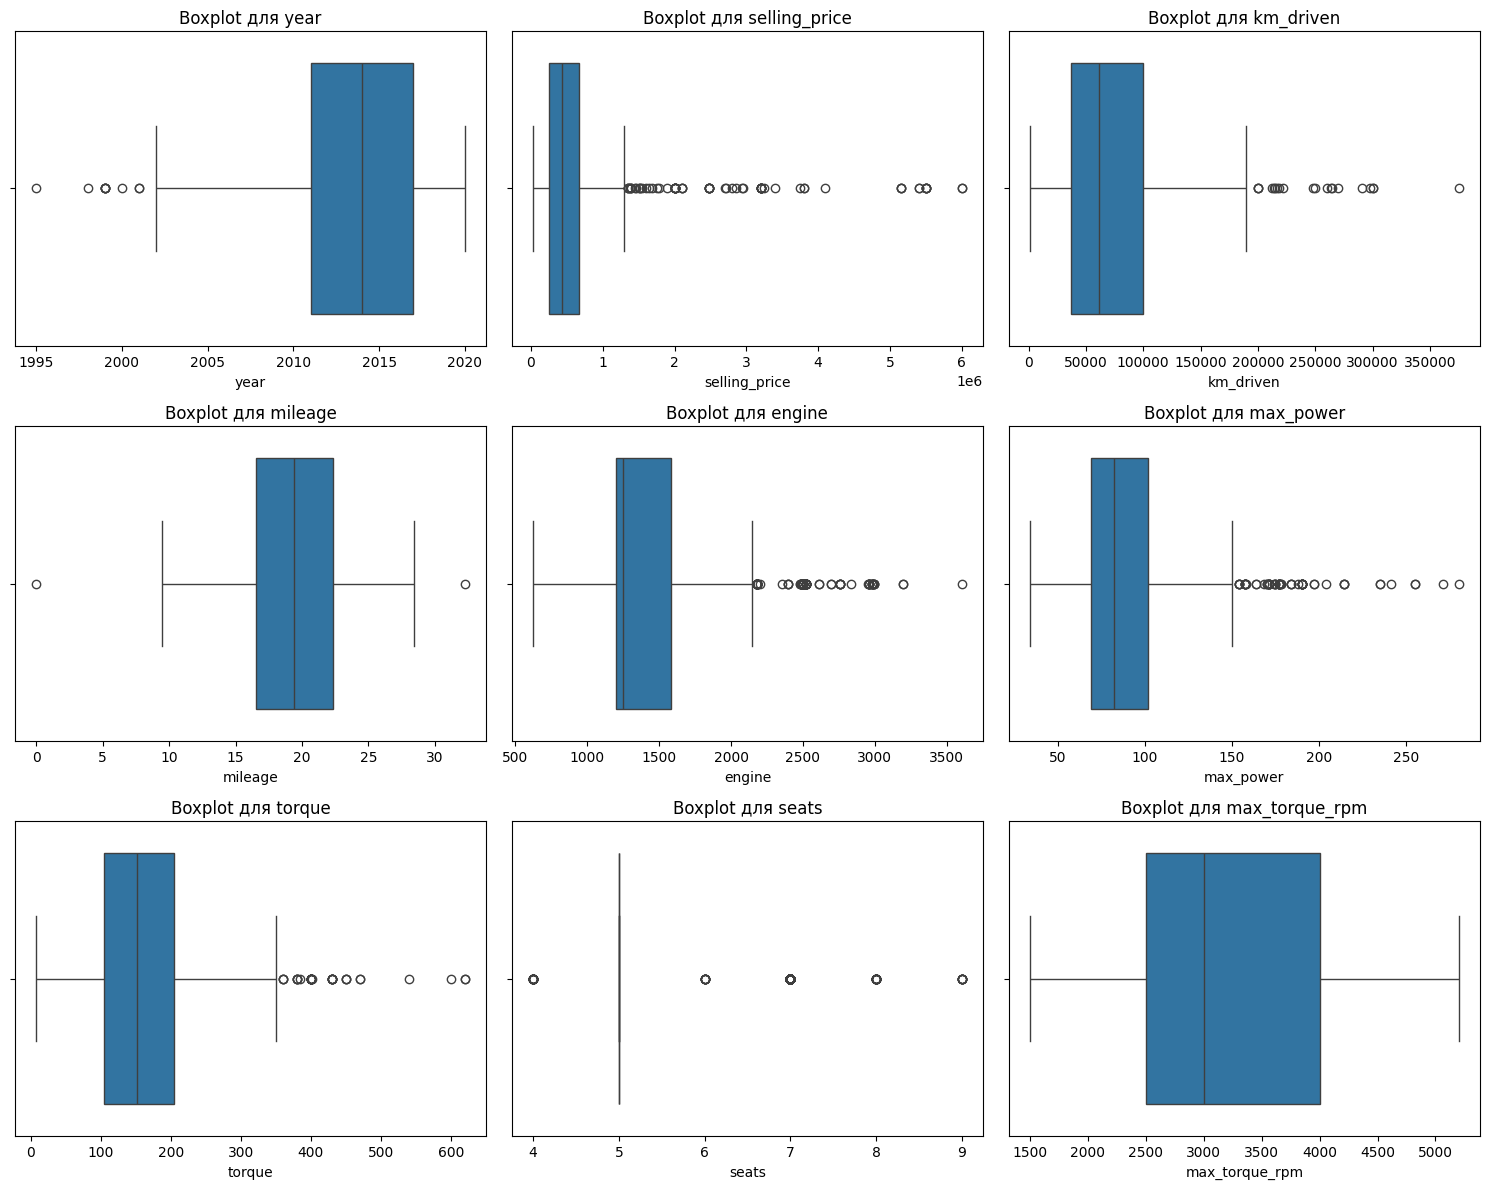

In [54]:
get_boxplots(df_test)

##### Boxplots для категориальных

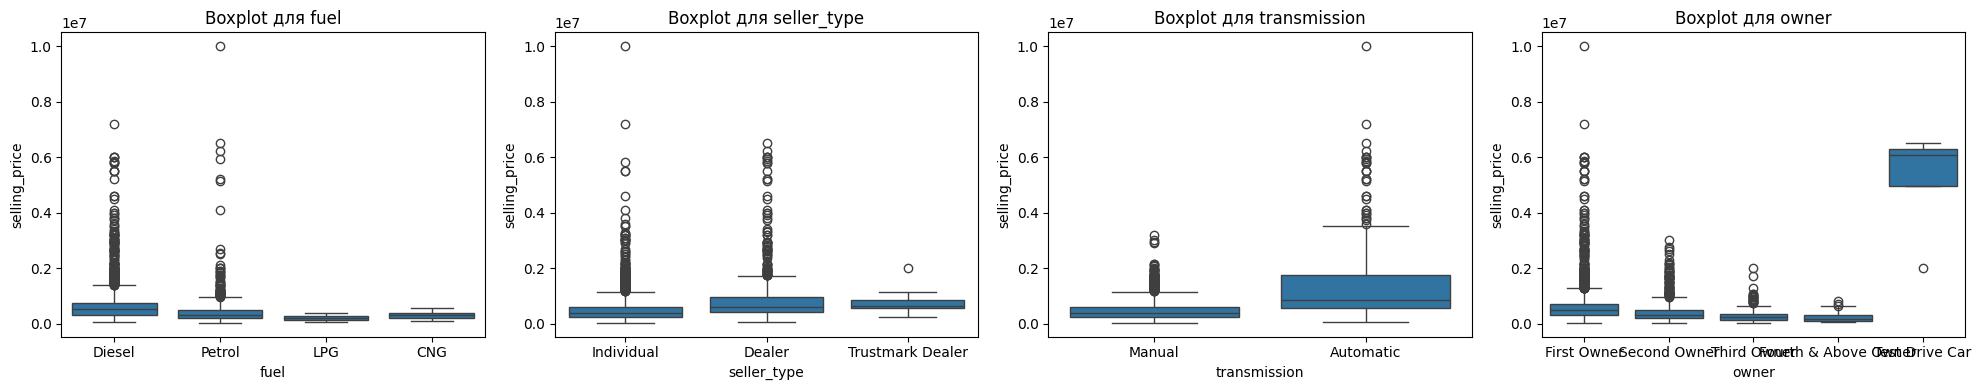

In [55]:
get_boxplots(df_train, numeric_cols=False)

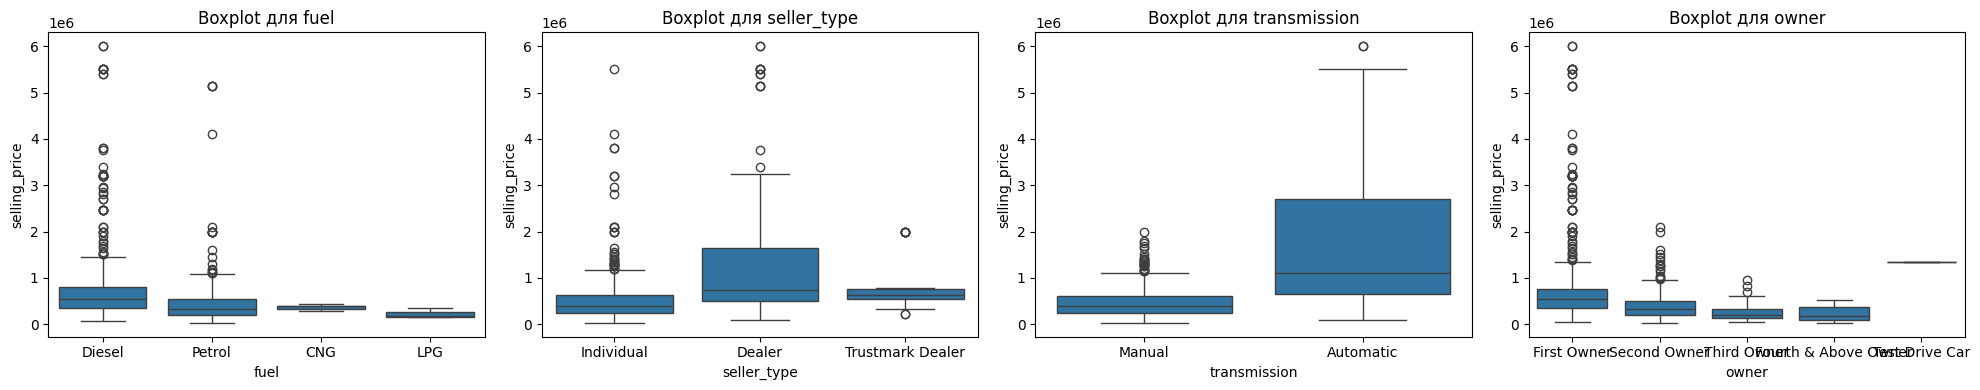

In [56]:
get_boxplots(df_test, numeric_cols=False)

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [57]:
df_train_num = df_train.copy()
df_test_num = df_test.copy()

df_train_num = df_train_num.select_dtypes(include='number')
df_test_num = df_test_num.select_dtypes(include='number')

In [ ]:
# разбиваем трейн на трейн и валидацию (!) (но надо валидационную назвать как test, поэтому оставила так)

X_train, X_test, y_train, y_test = train_test_split(
    df_train_num.drop('selling_price', axis=1),
    df_train_num['selling_price'],
    test_size=0.2,
    random_state=42 # на всякий еще и тут
)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [59]:
def get_r2_mse_metrics(y_train, preds_train, y_test, preds_test, digits=4):

    """
    Функция для расчета R2 и MSE
    """

    print("R2 на трейне:", np.round(r2_score(y_train, preds_train), digits))
    print("R2 на тесте:", np.round(r2_score(y_test, preds_test), digits))
    print("=" * 30)
    print("MSE на трейне:", np.round(MSE(y_train, preds_train), digits))
    print("MSE на тесте:", np.round(MSE(y_test, preds_test), digits))

In [60]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_preds_train = lr_model.predict(X_train)
lr_preds = lr_model.predict(X_test)

get_r2_mse_metrics(y_train, lr_preds_train, y_test, lr_preds)

R2 на трейне: 0.6082
R2 на тесте: 0.5568
MSE на трейне: 104940597679.8109
MSE на тесте: 160257133029.4418


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [61]:
def calculate_r2_score(y_true, y_pred):

    """
    Функция для расчета R2
    """
    # считаем среднее значение таргета = прямая горизонтальная линия
    y_mean = np.mean(y_true)
    # считаем дисперсию таргета = отклонение от среднего
    ss_total = np.sum((y_true - y_mean) ** 2)
    # считаем сумму квадратов остатков регрессии = отклонение от предсказаний модели
    ss_reg = np.sum((y_true - y_pred) ** 2)
    # считаем какую долю дисперсии таргета объясняет модель
    r2 = 1 - (ss_reg / ss_total)

    return r2

In [62]:
calculate_r2_score(y_train, lr_preds_train)

np.float64(0.6082491769080286)

In [63]:
calculate_r2_score(y_test, lr_preds)

np.float64(0.556830839116101)

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

R2 скорректированный штрафует за добавление дополнительных признаков в модель и позволяет сравнивать модели, которые отличаются только количеством признаков -> на качество модели теперь влияет только "качество" признаков и спецификация модели

In [64]:
def calculate_r2_score_adj(y_true, y_pred, n_features):

    """
    Функция для расчета R2 скорректированного
    """
    n_samples = len(y_true)

    # считаем среднее значение таргета = прямая горизонтальная линия
    y_mean = np.mean(y_true)
    # считаем дисперсию таргета = отклонение от среднего
    ss_total = np.sum((y_true - y_mean) ** 2)
    # считаем сумму квадратов остатков регрессии = отклонение от предсказаний модели
    ss_reg = np.sum((y_true - y_pred) ** 2)
    # считаем какую долю дисперсии таргета объясняет модель
    r2_adj = 1 - (ss_reg / ss_total) * ((n_samples - 1) / (n_samples - n_features - 1))

    return r2_adj

In [65]:
n_features = X_train.shape[1]
calculate_r2_score_adj(y_train, lr_preds_train, n_features)

np.float64(0.607577075989149)

In [66]:
n_features = X_train.shape[1]
calculate_r2_score_adj(y_test, lr_preds, n_features)

np.float64(0.55377186302717)

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
lr_model_with_scaled = LinearRegression()
lr_model_with_scaled.fit(X_train_scaled, y_train)

lr_preds_train_scaled = lr_model_with_scaled.predict(X_train_scaled)
lr_preds_scaled = lr_model_with_scaled.predict(X_test_scaled)

get_r2_mse_metrics(y_train, lr_preds_train_scaled, y_test, lr_preds_scaled)

R2 на трейне: 0.6082
R2 на тесте: 0.5568
MSE на трейне: 104940597679.811
MSE на тесте: 160257133029.443


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

Самый информативный признак для предсказания цены - максимальная мощность двигателя (max_power)

In [69]:
def get_feature_importance(model_coef, column_names):

    """
    Функция для получения важности признаков
    """
    
    df_coef = pd.DataFrame(list(zip(column_names, model_coef))).rename({0: 'feature', 1: 'reg_coefficient'}, axis=1)
    df_coef = df_coef.sort_values(by='reg_coefficient', key=lambda x: abs(x), ascending=False)

    return df_coef

In [70]:
get_feature_importance(lr_model_with_scaled.coef_, X_train.columns)

feature  reg_coefficient
4       max_power    278479.723827
0            year    160024.040433
1       km_driven    -67930.973679
7  max_torque_rpm    -53507.998173
3          engine     43666.088984
6           seats    -38579.453417
5          torque     31016.031521
2         mileage    -24055.737752

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

1. Качество практически не изменилось
2. Веса не занулились, так как использовали силу регуляризации (alpha) = 1, при этом этот параметр лежит в диапазоне от 0 до +бесконечности -> очень слабая регуляризация, эквивалентная обычному ols

In [71]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)

lasso_preds_train = lasso_model.predict(X_train_scaled)
lasso_preds = lasso_model.predict(X_test_scaled)

get_r2_mse_metrics(y_train, lasso_preds_train, y_test, lasso_preds)

R2 на трейне: 0.6082
R2 на тесте: 0.5568
MSE на трейне: 104940597693.935
MSE на тесте: 160256479979.467


In [72]:
get_feature_importance(lasso_model.coef_, X_train.columns)

feature  reg_coefficient
4       max_power    278480.514582
0            year    160021.845400
1       km_driven    -67929.851075
7  max_torque_rpm    -53505.409552
3          engine     43664.175241
6           seats    -38575.548053
5          torque     31016.417015
2         mileage    -24052.221031

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

1. 1 гиперпараметр * 300 значений * 1 гиперпараметр * 2 значения * 10 фолдов (fit на каждый фолд) = 6000
2. Расписала в функции 
3. В зависимости от метрики, если выбрать mse, то alpha=0, если r2, то 299 -> качество сильно не меняется. Никакие коэффициенты не занулились

In [73]:
def print_best_stats(search_result):

    """
    Посчитаем r2 и mse в среднем 
    """
    cv_res = pd.DataFrame(search_result.cv_results_)
    indx_r2 = cv_res['mean_test_r2'].argmax()
    indx_mse = cv_res['mean_test_neg_mean_squared_error'].argmax()
    
    print('=' * 50)
    print(f'params: {search_result.best_params_}')
    print('=' * 50)   
    print(f'best_score: {np.round(search_result.best_score_, 4)}')
    print('=' * 50)
    print('Лучшие параметры для R2')
    print('=' * 50)
    print(cv_res.loc[indx_r2, ['params', 'mean_test_r2', 'mean_test_neg_mean_squared_error']])
    print('=' * 50)
    print('Лучшие параметры для neg_mse')
    print('=' * 50)
    print(cv_res.loc[indx_mse, ['params', 'mean_test_r2', 'mean_test_neg_mean_squared_error']])

In [74]:
pipe_lasso = Pipeline([
    ('scaler', scaler),            
    ('lasso_model', Lasso())
])

In [75]:
params_lasso = {
    # сила регуляризации с шагом 1
    'lasso_model__alpha': np.arange(0, 300),
    # включаем ли интерсепт
    'lasso_model__fit_intercept': [True, False],
}

search_lasso = GridSearchCV(
    pipe_lasso,
    params_lasso,
    scoring=['neg_mean_squared_error', 'r2'],
    refit="neg_mean_squared_error",
    cv=10,  
)

search_lasso.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso_model', Lasso())]),
             param_grid={'lasso_model__alpha': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73...
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299]),
                         'lasso_model__fit_intercept': [True, False]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [76]:
print_best_stats(search_lasso)

params: {'lasso_model__alpha': np.int64(0), 'lasso_model__fit_intercept': True}
best_score: -105631154976.634
Лучшие параметры для R2
params                              {'lasso_model__alpha': 299, 'lasso_model__fit_intercept': True}
mean_test_r2                                                                                 0.6096
mean_test_neg_mean_squared_error                                               -105632382943.932449
Name: 598, dtype: object
Лучшие параметры для neg_mse
params                              {'lasso_model__alpha': 0, 'lasso_model__fit_intercept': True}
mean_test_r2                                                                             0.609571
mean_test_neg_mean_squared_error                                             -105631154976.634003
Name: 0, dtype: object


In [77]:
best_lasso = search_lasso.best_estimator_

gs_lasso_preds_train = best_lasso.predict(X_train)
gs_lasso_preds = best_lasso.predict(X_test)

get_r2_mse_metrics(y_train, gs_lasso_preds_train, y_test, gs_lasso_preds)

R2 на трейне: 0.6082
R2 на тесте: 0.5568
MSE на трейне: 104940597679.811
MSE на тесте: 160257133029.443


In [78]:
get_feature_importance(best_lasso['lasso_model'].coef_, X_train.columns)

feature  reg_coefficient
4       max_power    278479.723827
0            year    160024.040433
1       km_driven    -67930.973679
7  max_torque_rpm    -53507.998173
3          engine     43666.088984
6           seats    -38579.453417
5          torque     31016.031521
2         mileage    -24055.737752

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

1. 1 гиперпараметр * 300 значений * 1 гиперпараметр * 2 значения * 1 параметр * 11 * 10 фолдов (fit на каждый фолд) = 66000
2. В зависимости от метрики, если выбрать mse, то alpha=0, если r2, то 299 -> качество сильно не меняется
3. В целом нам не помогает регуляризация: не так много признаков, нет сильной мультиколлинеарности, получаем похожие метрики, так как +- одно и тоже оптимальное решение - близкое к обычной линейной регрессии

In [79]:
pipe_elnet = Pipeline([
    ('scaler', scaler),            
    ('elnet_model', ElasticNet())
])

params_elnet = {
    # сила регуляризации с шагом 1
    'elnet_model__alpha': np.arange(0, 300),
    # включаем ли интерсепт
    'elnet_model__fit_intercept': [True, False],
    # какая доля приходится на l1 vs l2 регулярицию
    'elnet_model__l1_ratio': np.arange(0, 1.1, 0.1),
}

search_elnet = GridSearchCV(
    pipe_elnet,
    params_elnet,
    scoring=['neg_mean_squared_error', 'r2'],
    refit="neg_mean_squared_error",
    cv=10,  
)

search_elnet.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('elnet_model', ElasticNet())]),
             param_grid={'elnet_model__alpha': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,...
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299]),
                         'elnet_model__fit_intercept': [True, False],
                         'elnet_model__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [80]:
print_best_stats(search_elnet)

params: {'elnet_model__alpha': np.int64(0), 'elnet_model__fit_intercept': True, 'elnet_model__l1_ratio': np.float64(0.0)}
best_score: -105631154976.634
Лучшие параметры для R2
params                              {'elnet_model__alpha': 299, 'elnet_model__fit_intercept': True, 'elnet_model__l1_ratio': 1.0}
mean_test_r2                                                                                                               0.6096
mean_test_neg_mean_squared_error                                                                             -105632382943.932449
Name: 6588, dtype: object
Лучшие параметры для neg_mse
params                              {'elnet_model__alpha': 0, 'elnet_model__fit_intercept': True, 'elnet_model__l1_ratio': 0.0}
mean_test_r2                                                                                                           0.609571
mean_test_neg_mean_squared_error                                                                           -105631154976.63

In [81]:
best_elnet = search_elnet.best_estimator_

elnet_preds_train = best_elnet.predict(X_train)
elnet_preds = best_elnet.predict(X_test)

get_r2_mse_metrics(y_train, elnet_preds_train, y_test, elnet_preds)

R2 на трейне: 0.6082
R2 на тесте: 0.5568
MSE на трейне: 104940597679.811
MSE на тесте: 160257133029.443


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



- понимала как написать градиентный спуск, но не очень знала как на каждом шаге правильно добалять штраф по кол-ву ненулевых весов, поэтому спросила у chatgpt и он дал несколько рекомендаций, я выбрала самую понятную для меня с занулением весов по трешхолду и написала, возможно, не точную реализацию, но было бы интересно узнать как надо было сделать правильно)
- улучшений в качестве нет, поскольку и так большие веса 

In [82]:
def linreg_with_l0(X, y, step=0.001, thresh=0.1, iter=500):

    """
    Линейная регрессия с псевдо-l0 регуляризацией
    Зануляем маленькие коэффициенты по трешхолду
    """
    n, ind_vars = X.shape

    b0 = 0
    w = np.zeros(ind_vars)

    for _ in range(1000):

        pred = b0 + X @ w

        w_orig = w - step * (2/n) * (X.T @ (pred - y))
        # занулять bias не хотим, поэтому считаем отдельно градиент
        b0 = b0 - step * (2/n) * np.sum((pred - y))
        
        w = np.where(abs(w_orig) >= thresh, w_orig, 0)

    return b0, w

def make_prediction(X, b0, w):

    return b0 + X @ w

In [83]:
def gridsearch_notcv(X_train, X_test, y_train, y_test, thresh_ls, step_ls):

    """
    Простой перебор параметров и вычисление метрик для LO
    """

    res_ls = []

    for thresh in tqdm(thresh_ls):
        for step in step_ls:

            b0, w = linreg_with_l0(X_train, y_train, step=step, thresh=thresh)

            l0_preds_train = make_prediction(X_train, b0, w)
            l0_preds = make_prediction(X_test, b0, w)

            r2_train = r2_score(y_train, l0_preds_train)
            mse_train = MSE(y_train, l0_preds_train)

            r2_test = r2_score(y_test, l0_preds)
            mse_test = MSE(y_test, l0_preds)

            res = {'thresh': thresh,
                   'step': step,
                   'r2_train': r2_train,
                   'mse_train': mse_train,
                   'r2_test': r2_test,
                   'mse_test': mse_test,
                   }
            
            res_ls.append(res)
    
    return pd.DataFrame(res_ls)

In [84]:
b0, w = linreg_with_l0(X_train_scaled, y_train)
l0_preds_train = make_prediction(X_train_scaled, b0, w)
l0_preds = make_prediction(X_test_scaled, b0, w)

get_r2_mse_metrics(y_train, l0_preds_train, y_test, l0_preds)

R2 на трейне: 0.578
R2 на тесте: 0.5019
MSE на трейне: 113040578526.3943
MSE на тесте: 180131669350.1424


In [85]:
thresh_ls = [0.1, 10, 100, 1000, 5000] 
step_ls = [0.01, 0.1]

search_l0 = gridsearch_notcv(X_train_scaled, X_test_scaled, y_train, y_test, thresh_ls, step_ls)

100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


In [86]:
search_l0

thresh  step  r2_train     mse_train   r2_test      mse_test
0     0.1  0.01  0.608141  1.049697e+11  0.554671  1.610381e+11
1     0.1  0.10  0.608249  1.049406e+11  0.556831  1.602571e+11
2    10.0  0.01  0.608141  1.049697e+11  0.554671  1.610381e+11
3    10.0  0.10  0.608249  1.049406e+11  0.556831  1.602571e+11
4   100.0  0.01  0.608141  1.049697e+11  0.554671  1.610382e+11
5   100.0  0.10  0.608249  1.049406e+11  0.556831  1.602571e+11
6  1000.0  0.01  0.600533  1.070077e+11  0.556582  1.603470e+11
7  1000.0  0.10  0.608249  1.049406e+11  0.556831  1.602571e+11
8  5000.0  0.01  0.487885  1.371832e+11  0.512194  1.763985e+11
9  5000.0  0.10  0.608249  1.049406e+11  0.556831  1.602571e+11

In [87]:
max_r2_indx = np.argmax(search_l0['r2_train'])
search_l0.iloc[max_r2_indx].apply(lambda x: f'{x:.3f}')

thresh                  0.100
step                    0.100
r2_train                0.608
mse_train    104940597679.811
r2_test                 0.557
mse_test     160257133030.091
Name: 1, dtype: object

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [88]:
df_train_cat = df_train.copy()
df_test_cat = df_test.copy()

In [89]:
# возьмем только марку авто
print(df_train_cat['name'].nunique())
df_train_cat['name'] = df_train_cat['name'].str.split().apply(lambda x: x[0])
print(df_train_cat['name'].nunique())

1924
30


In [90]:
# для стримлит
#df_train_cat.to_csv('df_train_cat_prep.csv', index=False)

In [91]:
X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    df_train_cat.drop('selling_price', axis=1),
    df_train_cat['selling_price'],
    test_size=0.2,
    random_state=42 # на всякий еще и тут
)

In [92]:
X_train_cat.describe(include='object')

name    fuel seller_type transmission        owner
count     4672    4672        4672         4672         4672
unique      30       4           3            2            5
top     Maruti  Diesel  Individual       Manual  First Owner
freq      1425    2525        4167         4266         2877

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

1. привела для примера, все равно включаем в пайплайн потом

In [93]:
cat_columns =  list(X_train_cat.select_dtypes('object').columns) + ['seats']

ohe = OneHotEncoder(drop ='first', handle_unknown='ignore')
ohe.fit_transform(X_train_cat[cat_columns])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 24218 stored elements and shape (4672, 47)>

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

1. OHE:
    - если число уникальных значений больше, например, 10, то желательно не применять -> для каждой категории создается отдельный столбец и если выборка не большая, то большое количество признаков может привести к проблеме в нахождении оптимального решения и не усточйчивости этого решения
    - рассматривать категории только на трейне, а незнакомы категории в тесте - игнорировать
    - удалять 1 категорию
2. иначе получается линейная зависимость, так как у нас уже есть колонка к константной = 1
3. не совсем понимаю, что такое "не важные" по весам, желательно 1) смотреть на стат значимость коэффициента 2) если наш таргет находится в околонулевых диапазонах, то околонулевой вес может также быть существенным. Если нет стат значимости у других категорий, то их можно удалить

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

- стало значительно лучше по метрикам: r2 вырос до 0.6842 с 0.5568 на тесте
- mse уменьшилась в 1.4 раза
- категориальные признаки оказались полезными в предсказании, как раз то, что увидели при исследовании корреляции
- но при этом если проверить финальные метрики на df_test (по факту наша тестовая выборка, X_test - это валидация), то метрики сильно просели: R2 на df_test: 0.332

In [94]:
num_cols = X_train_cat.drop(cat_columns, axis=1).columns

In [95]:
prep = ColumnTransformer([
    ('ohe', OneHotEncoder(drop ='first', handle_unknown='ignore', sparse_output=False), cat_columns),
    ('scaler', StandardScaler(), num_cols),
])

In [96]:
params_ridge = {
    # сила регуляризации с шагом 1
    'ridge_model__alpha': np.arange(0, 300),
    # включаем ли интерсепт
    'ridge_model__fit_intercept': [True, False],
}

pipe_ridge = Pipeline([
    ('prep', prep),            
    ('ridge_model', Ridge())
])

search_ridge = GridSearchCV(
    pipe_ridge,
    params_ridge,
    scoring=['neg_mean_squared_error', 'r2'],
    refit="r2",
    cv=10,  
)

search_ridge.fit(X_train_cat, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['name',
                                                                          'fuel',
                                                                          'seller_type',
                                                                          'transmission',
                                                                          'owner',
                                                                          'seats']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         Index(['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'max_torque_rpm'],
      dtype='object...
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299]),
                         'ridge_model__fit_intercept': [True, False]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

In [97]:
print_best_stats(search_ridge)

params: {'ridge_model__alpha': np.int64(1), 'ridge_model__fit_intercept': True}
best_score: 0.7587
Лучшие параметры для R2
params                              {'ridge_model__alpha': 1, 'ridge_model__fit_intercept': True}
mean_test_r2                                                                             0.758689
mean_test_neg_mean_squared_error                                              -63878334104.057228
Name: 2, dtype: object
Лучшие параметры для neg_mse
params                              {'ridge_model__alpha': 0, 'ridge_model__fit_intercept': True}
mean_test_r2                                                                             0.758182
mean_test_neg_mean_squared_error                                              -63844801223.172768
Name: 0, dtype: object


In [98]:
ridge_model = search_ridge.best_estimator_
ridge_model.fit(X_train_cat, y_train)

ridge_preds_train = ridge_model.predict(X_train_cat)
ridge_preds = ridge_model.predict(X_test_cat)

get_r2_mse_metrics(y_train, ridge_preds_train, y_test, ridge_preds)

R2 на трейне: 0.7879
R2 на тесте: 0.6842
MSE на трейне: 56826463755.7671
MSE на тесте: 114192918433.3647


In [ ]:
# финальный замер на df_test

# переобучаем на трейне + валидация
ridge_model_full = search_ridge.best_estimator_
ridge_model_full.fit(pd.concat([X_train_cat, X_test_cat]), pd.concat([y_train, y_test]))

ridge_preds_test = ridge_model_full.predict(df_test.drop('selling_price', axis=1))

print("R2 на df_test:", np.round(r2_score(df_test['selling_price'], ridge_preds_test), 3))
print("MSE на df_test:", np.round(MSE(df_test['selling_price'], ridge_preds_test), 3))

R2 на df_test: 0.332
MSE на df_test: 383935797695.364


In [100]:
# сохраняем эту модель для стримлит
# model_path = 'ridge_model.pkl'

# with open(model_path, 'wb') as f:
#     pickle.dump(ridge_model_full, f, protocol=pickle.HIGHEST_PROTOCOL)

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

- на трейне стало получше, а на тесте похуже по r2 и mse
- скорее всего переобучились немного
- НО: на df_test (реальная тестовая выборка, а не валидация) модель показала себя лучше
- к сожалению, к этому заданию немного подустала и закончились силы на творчество, можно было и правда поработаь с пропусками, включить interaction term из нескольких переменных, но кажется, что спецификация модели не очень удачная, возможно не линейные модели лучше уловят зависимость

In [101]:
# выбрала по графикам, взяла переменные со более скошенным распределением 

ln_cols = ['km_driven', 'max_power', 'torque', 'max_torque_rpm']
polynom_col = ['year']
scale_only_col = [x for x in num_cols if x not in ln_cols+polynom_col]

In [102]:
prep = ColumnTransformer([
    # только категориальные
    ('ohe', OneHotEncoder(drop ='first', handle_unknown='ignore', sparse_output=False), cat_columns),
    # только колонки для ln-трансформации
    ('num_log_scaled',
     Pipeline([
         ('log', FunctionTransformer(np.log1p)),
         ('scaler', StandardScaler()),
     ]), ln_cols),
    # year для года
    ('polynom2_scaled', 
     Pipeline([
        ('polynom2', PolynomialFeatures(2, include_bias=False)),
        ('scaler', StandardScaler())
     ]), polynom_col),
    # все остальные вещественные параллельно преобразовываем
    ('scaler', StandardScaler(), scale_only_col),
])

In [103]:
# в иделе прогнать все модели, но я сразу взяла лучшую по метрикам
pipe_ridge = Pipeline([
    ('prep', prep),            
    ('ridge_model', Ridge())
])

search_ridge_upd = GridSearchCV(
    pipe_ridge,
    params_ridge,
    scoring=['neg_mean_squared_error', 'r2'],
    refit="r2",
    cv=10,  
)

search_ridge_upd.fit(X_train_cat, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['name',
                                                                          'fuel',
                                                                          'seller_type',
                                                                          'transmission',
                                                                          'owner',
                                                                          'seats']),
                                                                        ('num_log_scaled',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['km_driven...
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299]),
                         'ridge_model__fit_intercept': [True, False]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

In [104]:
print_best_stats(search_ridge_upd)

params: {'ridge_model__alpha': np.int64(0), 'ridge_model__fit_intercept': False}
best_score: 0.7544
Лучшие параметры для R2
params                              {'ridge_model__alpha': 0, 'ridge_model__fit_intercept': False}
mean_test_r2                                                                              0.754441
mean_test_neg_mean_squared_error                                               -65100146981.158142
Name: 1, dtype: object
Лучшие параметры для neg_mse
params                              {'ridge_model__alpha': 0, 'ridge_model__fit_intercept': False}
mean_test_r2                                                                              0.754441
mean_test_neg_mean_squared_error                                               -65100146981.158142
Name: 1, dtype: object


In [105]:
ridge_model_upd = search_ridge_upd.best_estimator_
ridge_model_upd.fit(X_train_cat, y_train)

ridge_upd_preds_train = ridge_model_upd.predict(X_train_cat)
ridge_upd_preds = ridge_model_upd.predict(X_test_cat)

get_r2_mse_metrics(y_train, ridge_upd_preds_train, y_test, ridge_upd_preds)

R2 на трейне: 0.7902
R2 на тесте: 0.6566
MSE на трейне: 56188467879.99
MSE на тесте: 124161325823.2312


In [106]:
get_feature_importance(ridge_model_upd['ridge_model'].coef_, X_train_cat.columns).round(1)

feature  reg_coefficient
1             year        1750577.8
11           seats        1568850.7
0             name         998853.7
12  max_torque_rpm         836054.1
10          torque         539027.4
3             fuel         293855.9
6            owner        -151102.5
4      seller_type        -105129.1
8           engine          88915.1
9        max_power          80676.2
7          mileage          21121.5
5     transmission         -14258.9
2        km_driven          -5593.9

In [107]:
# финальный замер на df_test

ridge_model_full_upd = search_ridge_upd.best_estimator_
ridge_model_full_upd.fit(pd.concat([X_train_cat, X_test_cat]), pd.concat([y_train, y_test]))

ridge_upd_preds_test = ridge_model_full_upd.predict(df_test.drop('selling_price', axis=1))

print("R2 на df_test:", np.round(r2_score(df_test['selling_price'], ridge_upd_preds_test), 3))
print("MSE на df_test:", np.round(MSE(df_test['selling_price'], ridge_upd_preds_test), 3))

R2 на df_test: 0.376
MSE на df_test: 358419001948.991


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

- не сильно, но лучше решает бизнесовую задачу ridge регрессия с вещественными и категориальными фичами 

In [113]:
map_model_pred = {
    'lr': (lr_preds_train, lr_preds),
    'lr_scales': (lr_preds_train_scaled, lr_preds_scaled),
    'lasso': (lasso_preds_train, lasso_preds),
    'lasso_gs': (gs_lasso_preds_train, gs_lasso_preds),
    'elnet': (elnet_preds_train, elnet_preds),
    'ridge': (ridge_preds_train, ridge_preds),
    'ridge_my_features': (ridge_upd_preds_train, ridge_upd_preds)
}

In [114]:
def business_metrics(y_true, y_pred):
    return (abs(y_true - y_pred) / y_true <= 0.1).mean()

In [115]:
for model, preds in map_model_pred.items():
    
    preds_train, preds_test = preds
    
    print('='*50)
    print(f'Модель {model}')
    print(f'Значение метрики на тесте: {np.round(business_metrics(y_test, preds_test), 3)}')
    print('='*50)

Модель lr
Значение метрики на тесте: 0.229
Модель lr_scales
Значение метрики на тесте: 0.229
Модель lasso
Значение метрики на тесте: 0.229
Модель lasso_gs
Значение метрики на тесте: 0.229
Модель elnet
Значение метрики на тесте: 0.229
Модель ridge
Значение метрики на тесте: 0.287
Модель ridge_my_features
Значение метрики на тесте: 0.283


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



- одной из популярных не симметричных метрик является подход, при котором при недопрогнозе считаем квадрат отклонения, а при перепрогнозе модуль, тем самым сильнее штрафуем за недопрогноз
- и снова ridge регрессия с вещественными и категориальными фичами оказалась лучшей

In [116]:
def your_business_metrics(y_true, y_pred):
    
    return np.mean(np.where(y_true - y_pred > 0, (y_true - y_pred)**2, abs(y_true - y_pred)))

In [117]:
for model, preds in map_model_pred.items():
    
    preds_train, preds_test = preds
    
    print('='*50)
    print(f'Модель {model}')
    print(f'Значение метрики на тесте: {np.round(your_business_metrics(y_test, preds_test), 3)}')
    print('='*50)

Модель lr
Значение метрики на тесте: 136939049931.791
Модель lr_scales
Значение метрики на тесте: 136939049931.795
Модель lasso
Значение метрики на тесте: 136938535263.53
Модель lasso_gs
Значение метрики на тесте: 136939049931.795
Модель elnet
Значение метрики на тесте: 136939049931.795
Модель ridge
Значение метрики на тесте: 97657400375.539
Модель ridge_my_features
Значение метрики на тесте: 103508641027.225


# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 25**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)